In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Load the data from the CSV file
file_path = '../Data Clustering/Clustered_Data.csv'
data = pd.read_csv(file_path)

# Drop the specified columns
columns_to_drop = ['location', 'Lat_Long_Rounded', 'lga', 'state']
data = data.drop(columns=columns_to_drop)

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64087 entries, 0 to 64086
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   accident_count                 64087 non-null  int64  
 1   average_severity               64087 non-null  float64
 2   is_weekday_mean                64087 non-null  float64
 3   is_weekend_mean                64087 non-null  float64
 4   is_office_hours_mean           64087 non-null  float64
 5   is_non_office_hours_mean       64087 non-null  float64
 6   light_cond_day_mean            64087 non-null  float64
 7   light_cond_night_mean          64087 non-null  float64
 8   weather_cond_not_raining_mean  64087 non-null  float64
 9   weather_cond_raining_mean      64087 non-null  float64
 10  speed_less_or_equal_60_mean    64087 non-null  float64
 11  speed_greater_than_60_mean     64087 non-null  float64
 12  Latitude                       64087 non-null 

In [3]:
data = data.drop(columns=['ranking'])

In [4]:
# Extract feature names and label names
features = data.columns.drop('accident_prone_zone_rating').tolist()
label = 'accident_prone_zone_rating'

# Setting the order for accident_prone_zone_rating
data['accident_prone_zone_rating'] = pd.Categorical(data['accident_prone_zone_rating'], categories=['Low', 'Mid', 'High'], ordered=True)

# Define feature set and target variable
X = data[features]
y = data['accident_prone_zone_rating'].cat.codes

# Split data into training and testing sets using stratify option
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define categorical and numerical columns
categorical_cols = []
numerical_cols = [col for col in features if col not in categorical_cols]

In [5]:


# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data (currently empty)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define models with reduced complexity
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=46, class_weight='balanced', max_depth=5, n_estimators=50))
])

pipeline_svm = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', SVC(random_state=46, probability=True, class_weight='balanced', C=0.5, kernel='linear'))
])

pipeline_gb = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', GradientBoostingClassifier(random_state=46, max_depth=2, n_estimators=50, learning_rate=0.05))
])

# Fit the models on the training data
print("Fitting Random Forest...")
pipeline_rf.fit(X_train, y_train)
print("Fitting SVM...")
pipeline_svm.fit(X_train, y_train)
print("Fitting Gradient Boosting...")
pipeline_gb.fit(X_train, y_train)

Fitting Random Forest...
Fitting SVM...
Fitting Gradient Boosting...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['accident_count',
                                                   'average_severity',
                                                   'is_weekday_mean',
                                                   'is_weekend_mean',
                                                   'is_office_hours_mean',
                                                   'is_non_office_hours_mean',
                                                   'light_cond_day_mean',
                                                   'light_cond_night_mean',
                                                   'weather_cond_not_raining_mean',
                                                   'wea...
                                                   'speed_less_or_equal_60_mean',
                                                   'speed_greater_than_60_mean',
                                                   'Latitude', 'Longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.05, max_depth=2,
                                            n_estimators=50,
                                            random_state=46))])

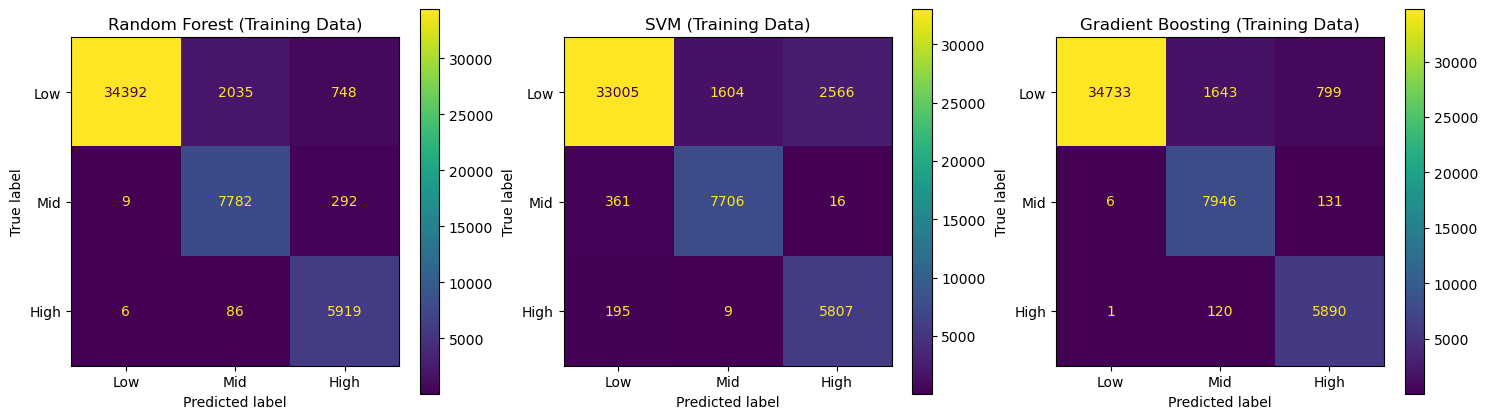

In [6]:
# Evaluate models using cross-validation on training data
def evaluate_model(model, X, y):
    y_pred_cv = cross_val_predict(model, X, y, cv=3)
    accuracy = accuracy_score(y, y_pred_cv)
    balanced_acc = balanced_accuracy_score(y, y_pred_cv)
    recall = recall_score(y, y_pred_cv, average='weighted', zero_division=0)
    precision = precision_score(y, y_pred_cv, average='weighted', zero_division=0)
    f1 = f1_score(y, y_pred_cv, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(y, y_pred_cv)
    
    return accuracy, balanced_acc, recall, precision, f1, conf_matrix

rf_metrics = evaluate_model(pipeline_rf, X_train, y_train)
svm_metrics = evaluate_model(pipeline_svm, X_train, y_train)
gb_metrics = evaluate_model(pipeline_gb, X_train, y_train)

# Plot confusion matrices for training data
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
ConfusionMatrixDisplay(rf_metrics[5], display_labels=['Low', 'Mid', 'High']).plot(ax=axs[0])
axs[0].set_title('Random Forest (Training Data)')
ConfusionMatrixDisplay(svm_metrics[5], display_labels=['Low', 'Mid', 'High']).plot(ax=axs[1])
axs[1].set_title('SVM (Training Data)')
ConfusionMatrixDisplay(gb_metrics[5], display_labels=['Low', 'Mid', 'High']).plot(ax=axs[2])
axs[2].set_title('Gradient Boosting (Training Data)')
plt.show()

In [7]:

# Compare models
metrics_df = pd.DataFrame({
    'Model': ['Random Forest', 'SVM', 'Gradient Boosting'],
    'Accuracy': [rf_metrics[0], svm_metrics[0], gb_metrics[0]],
    'Balanced Accuracy': [rf_metrics[1], svm_metrics[1], gb_metrics[1]],
    'Recall': [rf_metrics[2], svm_metrics[2], gb_metrics[2]],
    'Precision': [rf_metrics[3], svm_metrics[3], gb_metrics[3]],
    'F1 Score': [rf_metrics[4], svm_metrics[4], gb_metrics[4]]
})

# Select the best model based on Balanced Accuracy
best_model_name = metrics_df.loc[metrics_df['Balanced Accuracy'].idxmax(), 'Model']
best_model = {
    'Random Forest': pipeline_rf,
    'SVM': pipeline_svm,
    'Gradient Boosting': pipeline_gb
}[best_model_name]

# Output the results
print("Model Comparison Metrics:")
print(metrics_df)

print(f"The best model is: {best_model_name}")

Model Comparison Metrics:
               Model  Accuracy  Balanced Accuracy    Recall  Precision  \
0      Random Forest  0.938052           0.957531  0.938052   0.948395   
1                SVM  0.907332           0.935750  0.907332   0.924613   
2  Gradient Boosting  0.947337           0.965744  0.947337   0.955238   

   F1 Score  
0  0.940194  
1  0.910842  
2  0.948868  
The best model is: Gradient Boosting


In [8]:
# Evaluate the best model on the test set
y_test_pred = best_model.predict(X_test)

# Calculate the metrics for the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)

# Print the test set metrics
print(f"Test Set Metrics for the Best Model ({best_model_name}):")
print(f"Accuracy: {test_accuracy}")
print(f"Balanced Accuracy: {test_balanced_acc}")
print(f"Recall: {test_recall}")
print(f"Precision: {test_precision}")
print(f"F1 Score: {test_f1}")

Test Set Metrics for the Best Model (Gradient Boosting):
Accuracy: 0.9525667030738024
Balanced Accuracy: 0.9685015802581681
Recall: 0.9525667030738024
Precision: 0.9589556593625066
F1 Score: 0.9538018255577146


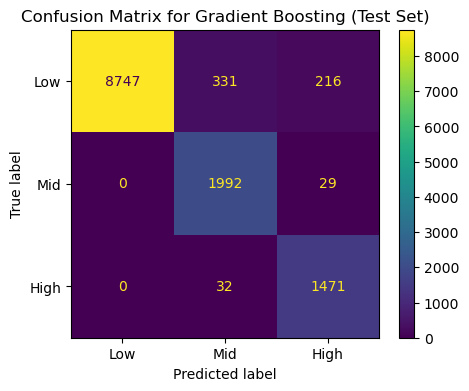

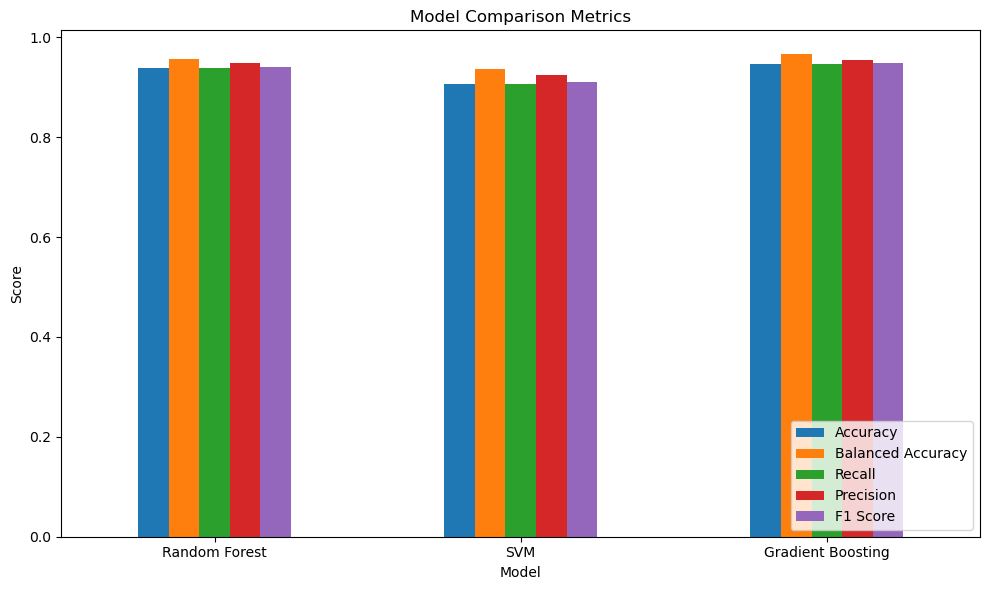

In [9]:

# Display the confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay(conf_matrix_test, display_labels=['Low', 'Mid', 'High']).plot(ax=ax)
ax.set_title(f"Confusion Matrix for {best_model_name} (Test Set)")
plt.show()

# Plot comparison of model metrics
metrics_df.set_index('Model', inplace=True)
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Model Comparison Metrics')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

Feature Importances for the Best Model:
                          Feature  Importance
0                  accident_count    0.574281
10    speed_less_or_equal_60_mean    0.180289
11     speed_greater_than_60_mean    0.161550
13                      Longitude    0.035714
6             light_cond_day_mean    0.018044
7           light_cond_night_mean    0.017045
4            is_office_hours_mean    0.007015
5        is_non_office_hours_mean    0.004869
9       weather_cond_raining_mean    0.000637
8   weather_cond_not_raining_mean    0.000428
12                       Latitude    0.000129
1                average_severity    0.000000
2                 is_weekday_mean    0.000000
3                 is_weekend_mean    0.000000


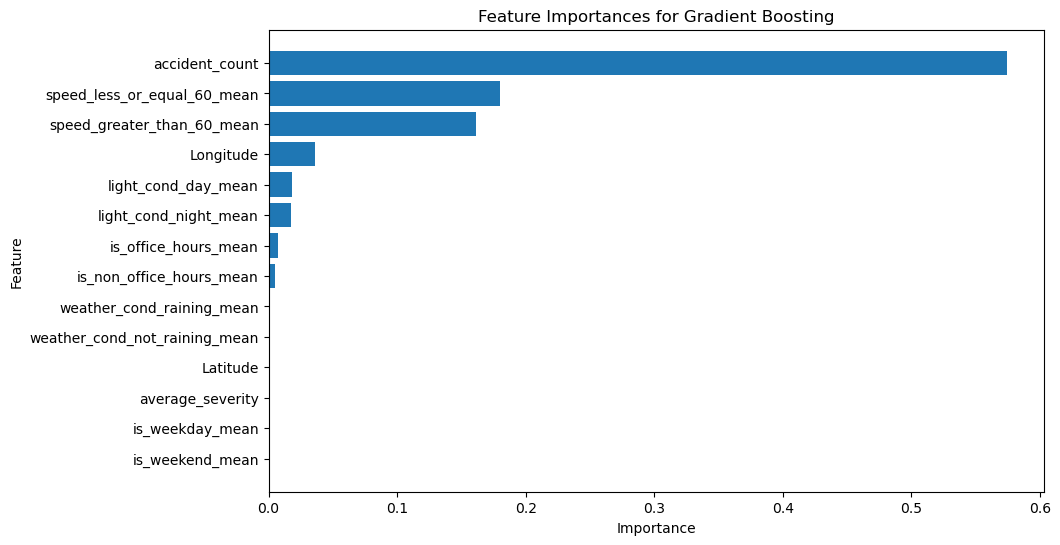

In [10]:
# Feature importance for the best model (if applicable)
if best_model_name == 'Random Forest' or best_model_name == 'Gradient Boosting':
    feature_importances = best_model.named_steps['classifier'].feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': numerical_cols,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
    # Display the feature importances
    print("Feature Importances for the Best Model:")
    print(feature_importance_df)
    
    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.gca().invert_yaxis()
    plt.title(f'Feature Importances for {best_model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()
